imports

In [2]:
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import util
from scipy.fft import fft, ifft, fftfreq, rfft
import pickle
from obspy import UTCDateTime
import scipy.signal as signal
from spectrum import *
from pylab import *
import matplotlib.path as mpltPath

earthquakes are stored in

In [8]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'

load full catalog

In [9]:
eq_list = os.listdir(root)

client = Client("IRIS")

cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml')

work out which of those have usable data

In [18]:
eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
loc = []
lats = []
longs = []
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])
        loc.append([event.origins[0].longitude, event.origins[0].latitude])
        lats.append(event.origins[0].latitude)
        longs.append(event.origins[0].longitude)

In [11]:
loc[0:10]

[[-20.4865, -69.0165],
 [8.9782, -83.7578],
 [56.298, -149.259],
 [17.9571, -68.3945],
 [53.5228, -167.2692],
 [19.3305, -68.2758],
 [-23.5661, -68.2039],
 [13.4636, -88.3658],
 [61.928, -149.8213],
 [19.168, -68.219]]

so we now have a list of earthquake names, and a catalog

we want to find earthquakes within a specific region, and produce a catalog + list of those.

to do this use the inbuilt matplotlib class path and path.contains_point

first we set up the path

# toy case

In [3]:
# regular polygon for testing
lenpoly = 100
polygon = [[np.sin(x)+0.5,np.cos(x)+0.5] for x in np.linspace(0,2*np.pi,lenpoly)[:-1]]

# random points set of points to test 
N = 10000
points = np.random.rand(N,2)

In [4]:
path = mpltPath.Path(polygon)
inside2 = path.contains_points(points)

In [5]:
polygon

[[0.5, 1.5],
 [0.56342391965656446, 1.4979866764718843],
 [0.62659245357374926, 1.4919548128307953],
 [0.68925124436041019, 1.4819286972627066],
 [0.75114798718107922, 1.4679487013963564],
 [0.81203344569848712, 1.4500711177409453],
 [0.87166245566032763, 1.4283679330160726],
 [0.92979491208917164, 1.4029265382866212],
 [0.98619673610046865, 1.373849377069785],
 [1.0406408174555977, 1.3412535328311812],
 [1.0929079290546404, 1.3052702575310586],
 [1.1427876096865393, 1.2660444431189779],
 [1.190079011482112, 1.2237340381050701],
 [1.2345917086575333, 1.1785094115571322],
 [1.2761464642917568, 1.1305526670845225],
 [1.3145759520503357, 1.0800569095711983],
 [1.3497254299495145, 1.0272254676105024],
 [1.3814533634475821, 0.97227107477268271],
 [1.4096319953545184, 0.91541501300188644],
 [1.4341478602651065, 0.85688622159187189],
 [1.4549022414440738, 0.79692037532827498],
 [1.4718115683235418, 0.73575893550942728],
 [1.4848077530122081, 0.67364817766693041],
 [1.4938384644612541, 0.61083

# rectangle in the real world

In [28]:
from matplotlib.path import Path
polygon = [[-10,-10], [-10,10], [10, 10], [10, -10], [-10,-10]]
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]


In [29]:
path = mpltPath.Path(polygon, codes)
inside2 = path.contains_points(points)

In [30]:
polygon

[[-10, -10], [-10, 10], [10, 10], [10, -10], [-10, -10]]

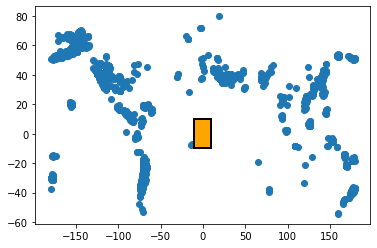

In [32]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
ax.scatter(longs, lats)

In [33]:
import numpy as np

from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path


class SelectFromCollection(object):
    """Select indices from a matplotlib collection using `PolygonSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : :class:`~matplotlib.axes.Axes`
        Axes to interact with.

    collection : :class:`matplotlib.collections.Collection` subclass
        Collection you want to select from.

    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to `alpha_other`.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.poly = PolygonSelector(ax, self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.poly.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()




this polygon selection doesn't owrk in jupyter notebook

Select points in the figure by enclosing them within a polygon.
Press the 'esc' key to start a new polygon.
Try holding the 'shift' key to move all of the vertices.
Try holding the 'ctrl' key to move a single vertex.


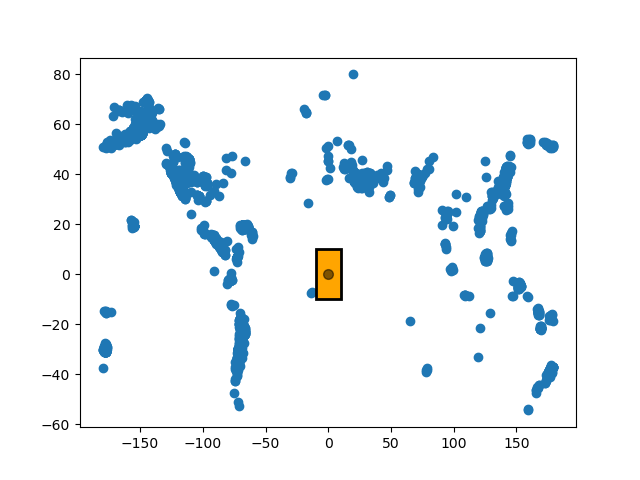


Selected points:
[]


In [37]:


ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

fig, ax = plt.subplots()
#patch = patches.PathPatch(path, facecolor='orange', lw=2)
#ax.add_patch(patch)
pts = ax.scatter(longs, lats)

selector = SelectFromCollection(ax, pts)

print("Select points in the figure by enclosing them within a polygon.")
print("Press the 'esc' key to start a new polygon.")
print("Try holding the 'shift' key to move all of the vertices.")
print("Try holding the 'ctrl' key to move a single vertex.")

plt.show()

selector.disconnect()

# After figure is closed print the coordinates of the selected points
#print('\nSelected points:')
#print(selector.xys[selector.ind])
polygon_x_coords = selector.poly._xs_at_press
polygon_y_coords = selector.poly._ys_at_press

polygon = []
codes = []
for i in range(len(polygon_x_coords)):
    polygon.append([polygon_x_coords[i], polygon_y_coords[i]])
    codes.append(Path.LINETO)
    
codes[0] = Path.MOVETO,
codes.append(Path.CLOSEPOLY,)
polygon.append([polygon_x_coords[0], polygon_y_coords[0]])


path = mpltPath.Path(polygon)
fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
pts = ax.scatter(longs, lats)
plt.show()
inside2 = path.contains_points(points)
indices_inside = np.where(inside2)

name = input()



In [ ]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='orange', lw=2, alpha = 0.5)
ax.add_patch(patch)
ax.scatter(longs, lats)

In [38]:
import pandas as pd
polygons_df = pd.DataFrame({"polygons":[], "eq_lists":[], "catalogs":[]})
polygons_df
new_line = pd.Series({'polygons':polygon, 'eq_lists':eq_with_data, 'catalogs':cat_with_data}, name='south america')
polygons_df = polygons_df.append(new_line, ignore_index = False)
polygons_df

In [39]:
polygons_df

,names,polygons,eq_lists,catalogs


In [ ]:
new_line = pd.Series(name='south america',{'polygons':polygon, 'eq_lists':[], 'catalogs':cat_with_data})